# The HFM library - A fast marching solver with adaptive stencils
## Part B. Application examples
## Chapter III. Object segmentation

This python notebook is intended as a companion notebook for the manuscript:  
<a id="mirebeau_ipol_2018">Jean-Marie Mirebeau, Jorg Portegies, "A fast marching solver with adaptive stencils", 2018 (submitted)</a>  
and as documentation for the [HamiltonFastMarching (HFM) library](https://github.com/mirebeau/HamiltonFastMarching), which also has interfaces to the Matlab&reg; and Mathematica&reg; languages. It is part of a series, see the [summary](http://nbviewer.jupyter.org/urls/rawgithub.com/Mirebeau/HFM_Python_Notebooks/master/Summary.ipynb).

We illustrate several approaches of using the fast marching algorithm for object segmentation in natural images. In particular, techniques such as dimension lifting and curvature penalization are demonstrated. 
Object segmentation in natural images is a domain of research in itself, on which the author only has moderate expertise, and to which numerous alternative approaches can be applied. Hence this notebook has no pretention to being exhaustive or state of the art, but should only be regarded as an advanced demo of the HFM library.

## 0. Preliminary imports

### 0.1 Required libraries

We begin by setting up the environnement for calling the Hamiltonian-Fast-Marching (HFM) library, importing a few additional libraries, and defining some commodity functions.

In [62]:
import HFMUtils
# !!! Please replace with the directory containing the FileHFM executable on your machine
HFMUtils.FileHFM_binary_dir = '/Users/mirebeau/bin/HamiltonFastMarching/FileHFM/Release'
from HFMUtils import GetGeodesics

In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # Plots geodesics
from scipy import ndimage
from itertools import groupby
from copy import deepcopy

In [3]:
# Commodity functions
def DeleteConsecutiveDuplicates(L): 
    return np.array([x[0] for x in groupby(L, lambda x:tuple(x))])
def MyArgmin(positions,indices,cost,lvl):
    return np.array([(x,y,lvl[np.argmin(cost[j,i,:])]) for ((x,y),(i,j)) in zip(positions,indices)])

In [4]:
mplImport = False # Import images using matplot lib (often restricted to png)
def ImportImage(path):
    if mplImport:
        import matplotlib.image
        return matplotlib.image.imread(path)
    else:
        import requests
        import PIL.Image
        from io import BytesIO
        response = requests.get(path)
        return np.array(PIL.Image.open(BytesIO(response.content)))

## 1. Isotropic fast marching

### 1.1 The object contour as a front boundary

In [5]:
image = ImportImage('https://dl.dropbox.com/s/6v2rfr4niuj0v3z/mri_nonuniform.bmp').astype(float)/255.

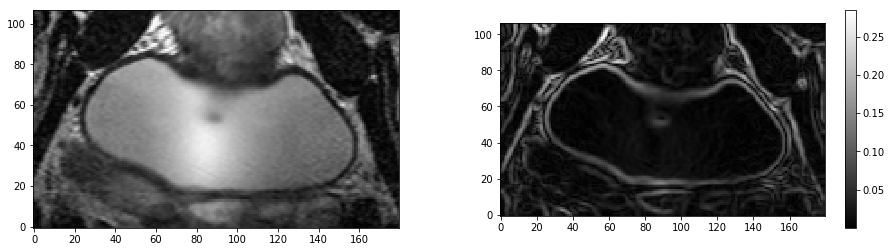

In [6]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1); plt.imshow(image,cmap='gray',origin='lower');

#Dy,Dx = np.gradient(ndimage.filters.gaussian_filter(image,1.)); gradNorm = np.sqrt(Dx**2+Dy**2);
gradNorm = ndimage.gaussian_gradient_magnitude(image,1) 
plt.subplot(1,2,2); plt.imshow(gradNorm,cmap='gray',origin='lower');
plt.colorbar();

In [7]:
isoIn = {}

In [8]:
isoIn['model'] = 'Isotropic2'
isoIn['arrayOrdering'] = 'YXZ_RowMajor'

nY,nX = image.shape
isoIn['dims'] = [nX,nY]
isoIn['gridScale'] = 1
isoIn['cost'] = gradNorm**2
isoIn['exportValues'] = 1
isoIn['seeds'] = [[100,50]]

In [10]:
isoOut = HFMUtils.Run(isoIn)

In [11]:
X,Y = np.meshgrid(range(nX),range(nY))

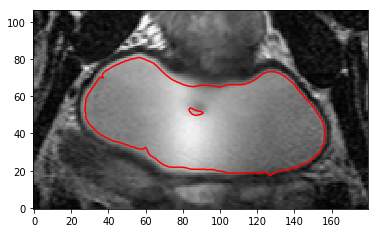

In [12]:
plt.contour(X,Y,isoOut['values'],levels=[0.0095],colors='red');
plt.imshow(image,cmap='gray',origin='lower');

### 1.2 The object contour as a minimal path

In [13]:
isoIn['cost'] = 0.1+np.exp(-250*gradNorm**2)
isoIn['seeds'] = np.array([[100,19]])
isoIn['tips'] = np.array([[120,70],[70,75]])
isoIn.pop('exportValues',None);

In [15]:
isoOut = HFMUtils.Run(isoIn)

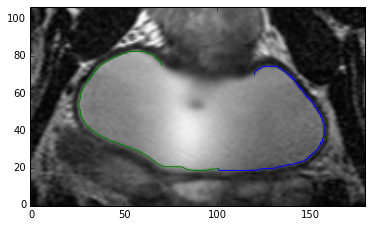

In [132]:
for geo in GetGeodesics(isoOut): plt.plot(geo[:,0],geo[:,1])
plt.imshow(image,cmap='gray',origin='lower');

## 2. Riemannian techniques

Build up some descriptor, take gradient and square it -> Riemannian metric.
Could even be the structure tensor.

In [37]:
riemIn = {}

In [50]:
image = ImportImage('https://dl.dropbox.com/s/670sdp2k4r25ftw/flower.jpg').astype(float)/255.
#
#https://dl.dropbox.com/s/c8zfelcrppasks0/pict2272.png?dl=0

In [51]:
riemIn['model'] = 'Riemann2'
riemIn['arrayOrdering'] = 'YXZ_RowMajor'

nY,nX,_ = image.shape
riemIn['dims'] = np.array([nX,nY])
riemIn['gridScale']=1

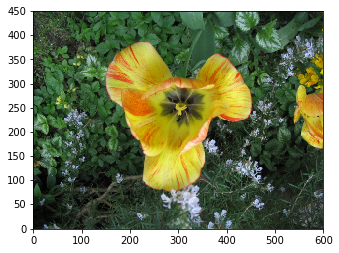

In [52]:
plt.imshow(image,origin='lower');

In [53]:
def StructureTensor(image,sigma=1,rho=2):
    im = ndimage.gaussian_filter(image,[sigma,sigma,0])
    Dx,Dy = ndimage.sobel(im,0), ndimage.sobel(im,1)
    tensor = np.sum(np.array([Dx**2,Dx*Dy,Dy**2]),axis=3).transpose(1,2,0)
    return ndimage.gaussian_filter(tensor,[rho,rho,0])

In [54]:
st = StructureTensor(image)

In [55]:
# Apply a function to a 2x2 symmetric tensor field
def Eigenvalues(tensors):
    #det = tensors[:,:,0]*tensors[:,:,2]-tensors[:,:,1]**2
    htr = (tensors[:,:,0]+tensors[:,:,2])/2
    dlt = np.sqrt(0.25*(tensors[:,:,2]-tensors[:,:,0])**2+tensors[:,:,1]**2)
    return htr-dlt,htr+dlt # l2 is the largest eigenvalue

def MapTensorField(fct,tensors):
    l1,l2 = Eigenvalues(tensors)
    r1,r2 = fct(l1,l2)
    a=(r2-r1)/(l2-l1); b=(l2*r1-l1*r2)/(l2-l1)
    
    result=np.zeros(tensors.shape)
    result[:,:,0]=a*tensors[:,:,0]+b
    result[:,:,1]=a*tensors[:,:,1]
    result[:,:,2]=a*tensors[:,:,2]+b    
    return result

In [56]:
def MyFunc(l1,l2): # Favorable along e1 when l2 is much larger than 1+l1
    alpha=0.5; beta=0.1; cond=10;
    return np.minimum(cond,np.exp(alpha*((beta+l2)/(beta+l1)-1))),1

In [57]:
riemIn['dualMetric'] = MapTensorField(MyFunc,st)

In [58]:
riemIn['seeds']=[[300,90]]
riemIn['tips']=[[400,340],[250,380]]

In [59]:
riemOut = HFMUtils.Run(riemIn)

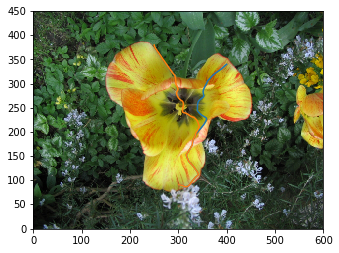

In [63]:
for geo in GetGeodesics(riemOut): plt.plot(geo[:,0],geo[:,1])
plt.imshow(image,origin='lower');

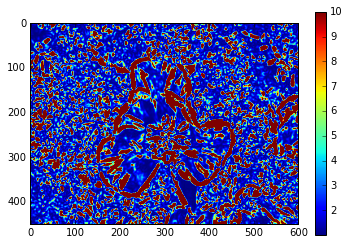

In [263]:
l1,l2 = Eigenvalues(st)
r1,_ = MyFunc(l1,l2)
plt.imshow(r1)
plt.colorbar();

In [223]:
dm = riemIn['dualMetric']
det = dm[:,:,2]*dm[:,:,0]-dm[:,:,1]**2

In [224]:
np.max(det)

49.487311531770061

In [204]:
det[:][86756]

IndexError: index 86756 is out of bounds for axis 0 with size 450

In [197]:
MapTensorField(MyFunc,np.array([[[1,0,1.01]]]))

array([[[ 1.00501252, -0.        ,  1.        ]]])

## 3 Asymmetric techniques and curvature penalization

In [137]:
np.sum(image,axis=2).shape

(450, 600)